In [25]:
%matplotlib inline

import json
import seaborn as sns
import seaborn.objects as so
import subprocess
import pandas as pd
from pathlib import Path
from tempfile import NamedTemporaryFile
from typing import Literal

In [2]:
%%sh

CPU=$(($(nproc) - 1))

for i in `seq 0 $CPU`
do
  sudo cpufreq-set -c $i -g userspace
  sudo cpufreq-set -c $i -d 2.90GHz
  sudo cpufreq-set -c $i -u 2.90GHz
  sudo cpufreq-set -c $i -f 2.90GHz
done

In [62]:
JACCARD_BINARY = Path("../build/jaccard")


def run_jaccard_evolve(
    graph: Literal["LS_CSR", "CSR_64", "MOR_GR", "LC_MOR_GR"] = "LS_CSR",
    n: int = 10_000,
    m: int = 10,
    p: float = 0.15,
):
    with NamedTemporaryFile(
        "r", prefix=f"{graph}-n={n}-m={m}-p={p:.2f}-", suffix=".txt", delete=False
    ) as stats_file:
        jaccard_proc = subprocess.run(
            [
                JACCARD_BINARY,
                f"-g={graph}",
                # f"-n={n}",
                # f"-m={m}",
                # f"-p={p}",
                "--style=EVOLVE",
                "--out=NON",
                "--inpfile=/var/local/graphs/com-friendster_graph.el",
                "--stats",
                stats_file.name,
            ],
        )
        jaccard_proc.check_returncode()

        results = list(map(json.loads, stats_file.readlines()))
        for result in results:
            (g, _e, stage, step) = result["name"].split()
            (step, max_step) = tuple(map(int, step.split("/")))
            result["graph"] = g
            result["stage"] = stage
            result["step"] = step
            result["max_step"] = max_step

        return results

In [63]:
results = []

In [64]:
exp_args = {"n": 10_000, "m": 10, "p": 0.15}
for graph in ["LS_CSR", "LC_MOR_GR"]:
    results += run_jaccard_evolve(graph=graph, **exp_args)

File Read Time (ns):	106187656510


KeyboardInterrupt: 

In [44]:
# todo: for each stage, plot graph of cycles vs step, with cycles grouped by graph.
results_flat = []
for result in results:
    for run in result["runs"]:
        results_flat.append(run | {k: result[k] for k in result.keys() if k != "runs"})
        
        

In [45]:
df = pd.DataFrame.from_records(results_flat)

In [46]:
sns.set_theme()

/home/mzinn/anaconda3/envs/graph-log-sketch/lib/python3.10/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):
/home/mzinn/anaconda3/envs/graph-log-sketch/lib/python3.10/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


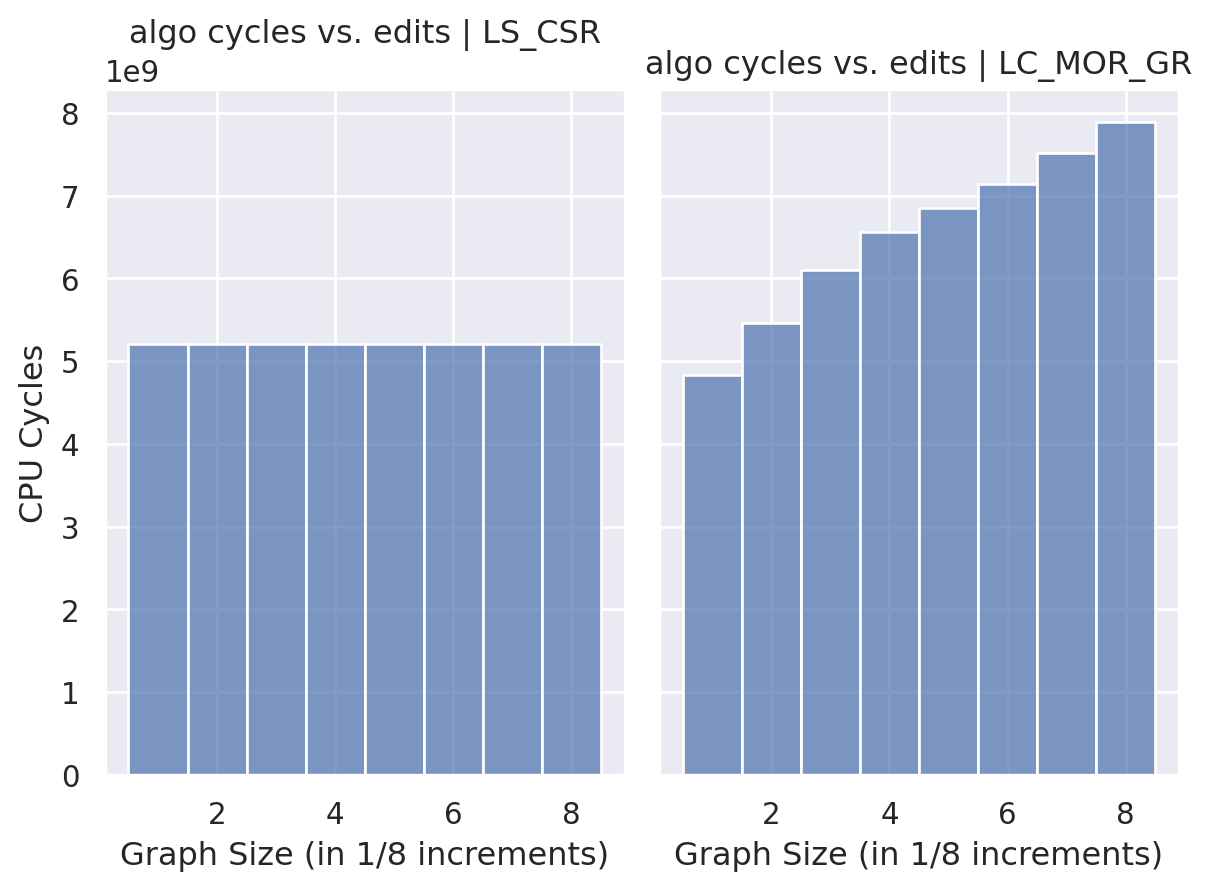

In [55]:
# sns.catplot(df[df["stage"] == "Algo"], x="step", y="cycles", col="graph", kind="bar") \
#     .label(x = "Portion of graph ingested")


(
    so.Plot(df[df["stage"] == "Algo"], x = "step", y = "cycles")
    .facet(col = "graph")
    .add(so.Bars())
    .label(x = "Graph Size (in 1/8 increments)", y = "CPU Cycles", title="algo cycles vs. edits | {}".format)
)

In [5]:
%%sh

CPU=$(($(nproc) - 1))

for i in `seq 0 $CPU`
do
  sudo cpufreq-set -c $i -g powersave
  sudo cpufreq-set -c $i -u 3.30GHz
  sudo cpufreq-set -c $i -d 1.20GHz
done